<a href="https://colab.research.google.com/github/s-jainr/deep-learning-sp23/blob/main/deep_learning_sentiment_thingy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from keras.utils import to_categorical, pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

!pip install pytreebank
import pytreebank
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Load the dataset from disk
dataset = pytreebank.load_sst("/path/to/sentiment/")

train_data = dataset['train']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
# Example sentence data and sentiment ratings
sentences = []
sentiment_ratings = []

for tree in train_data:
  datapoint = tree.to_labeled_lines()[0]
  sentiment_ratings.append(datapoint[0])
  sentences.append(datapoint[1])

In [30]:
# Tokenize sentences and convert sentiment ratings to categorical labels
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index
max_sequence_length = max([len(seq) for seq in sequences])
data = pad_sequences(sequences, maxlen=max_sequence_length)
labels = to_categorical(sentiment_ratings)

In [31]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 100

# Define the model
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))  # 5 classes (0-4)

In [33]:
# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

model.fit(train_data, train_labels, validation_data = (test_data, test_labels), epochs=1000, batch_size=32, callbacks=[es])

Epoch 1/10
214/214 [==============================] - 67s 297ms/step - loss: 1.5355 - accuracy: 0.3084 - val_loss: 1.4261 - val_accuracy: 0.3663
Epoch 2/10
214/214 [==============================] - 91s 424ms/step - loss: 1.1985 - accuracy: 0.4947 - val_loss: 1.3562 - val_accuracy: 0.4154
Epoch 3/10
214/214 [==============================] - 91s 427ms/step - loss: 0.7680 - accuracy: 0.7097 - val_loss: 1.5944 - val_accuracy: 0.3991
Epoch 4/10
214/214 [==============================] - 82s 385ms/step - loss: 0.4118 - accuracy: 0.8597 - val_loss: 1.9061 - val_accuracy: 0.3821
Epoch 5/10
214/214 [==============================] - 86s 402ms/step - loss: 0.2270 - accuracy: 0.9266 - val_loss: 2.2568 - val_accuracy: 0.3739
Epoch 6/10
214/214 [==============================] - 89s 417ms/step - loss: 0.1451 - accuracy: 0.9573 - val_loss: 2.5267 - val_accuracy: 0.3792
Epoch 7/10
214/214 [==============================] - 85s 398ms/step - loss: 0.0866 - accuracy: 0.9753 - val_loss: 2.8732 - val_ac

In [34]:
# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

54/54 [==============================] - 1s 24ms/step - loss: 3.3498 - accuracy: 0.3616
Test Accuracy: 36.16%


54/54 [==============================] - 3s 61ms/step


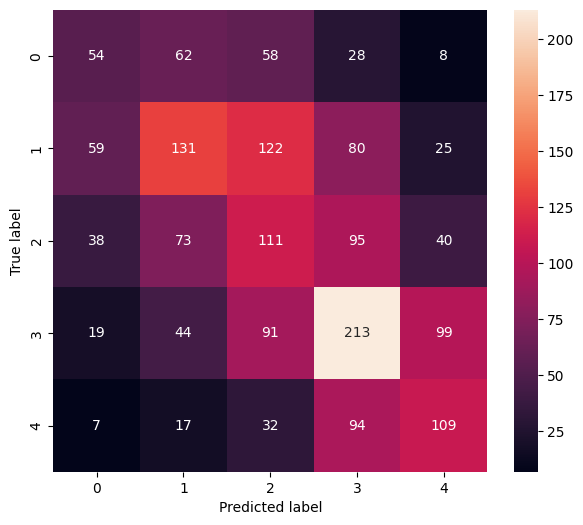

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# calculate the confusion matrix
preds = model.predict(test_data)
conf = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(preds, axis=1))

# plot the confusion matrix as a heatmap
plt.figure(figsize=(7,6))
sns.heatmap(conf, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()